# 공사현장 안전 데이터 AI 해커톤 (2번)

- 작성된 환경: Window 11, Python 3.9, CUDA 11.8, Anaconda & Jupyter with VScode, PowerShell
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

- CMD 혹은 POWERSHELL에서
``` shell
git clone https://github.com/lukemelas/EfficientNet-PyTorch
cd EfficientNet-Pytorch
pip install -e .
```

- 데이터 파일을 root 경로(skeleton.ipynb가 있는 폴더)에 압축해제 해주세요<br>
<br>예시: <br><br>
root(industrial_safety_data_AI_Hackaton)<br>
&nbsp;ㄴ S63_DATA1-0.01<br>
&nbsp;&nbsp;ㄴ C1<br>
&nbsp;&nbsp;ㄴ G1<br>
&nbsp;&nbsp;ㄴ H1<br>
&nbsp;&nbsp;ㄴ I1<br>
&nbsp;&nbsp;ㄴ T1<br>

## 모델 학습 (with Pretrained EfficientNet-B0)
- 기학습되지 않은 EfficientNet-B0의 구조만 활용하는 학습 추가 예정

### 모듈 불러오기

In [1]:
import time
import copy
import random
import glob
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [2]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)
  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA GeForce RTX 2070
2.1.1+cu121
12.1
tensor([-1.7661], device='cuda:0')


device(type='cuda', index=0)

### 하이퍼 파라미터 (Hyper Parameter)
- 필요에 따라 수정(추가 및 삭제 가능)
- mean, standard deviation은 수정 비추천
- seed를 고정값으로 사용하면 커널을 초기화하고 다시 Run을해도 고정된 학습결과가 나타남. 테스트나 확인해야할 사항이 있을 때 seed 임의조절 가능.

In [23]:
params = {
  # If you want to fix the results, change this value to constants
  'seed': random.randrange(1, 10000000),

  # For Efficientnet-B0
  'use_pretrained_model': True, # 기학습 모델 사용 여부 (전이학습)
  'dropout_rate': 0.2, # Effinet Default is 0.2
  
  # For Train
  'epoch': 30,
  'batch_size': 24,

  # CPU worker
  # - 작업관리자 등을 통해 CPU, GPU 그래프를 참고하며 조절
  # - GPU가 지그재그되는 간격이 넓다면 worker가 데이터를 GPU에 넘기는 속도보다 GPU가 계산을 끝내는 속도가 더 빠르다는 의미
  # - CPU가 100%로 피크를 찍을 시 worker 수를 줄이는 것을 추천. 병목현상으로 GPU가 제대로 일을 못할 수 있음
  # - worker는 너무 많아도 너무 적어도 안됨. 적당한 수치일 때 최고의 학습속도 달성 가능
  'workers': 8, # 본인 cpu 쓰레드의 절반 정도
  
  # For DataLoader, DataSet
  'num_show_img': 6, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음
  'mean': [0.485, 0.456, 0.406], # For 정규화, 과적합 방지
  'std': [0.229, 0.224, 0.225], # For 정규화, 과적합 방지
  
  # For Optimizer & Scheduler
  'learning_rate': 0.003,
  'momentum': 0.9, # For SGD
  'betas': (0.9, 0.999), # For Adam
  'weight_decay': 1e-4, # For SGD, Adam
  
}

### 이미지 확인 함수

In [24]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = params['std'] * input + params['mean']
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

### Train 함수

In [25]:
def train_model(model, criterion, optimizer, scheduler, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode
      
      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1
      #Iterate over data.
      pbar_dataloaders = tqdm(dataloaders[phase],
                              desc=phase,
                              ncols=70)
      for inputs, labels in pbar_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_cnt += len(labels)
        count += 1
      pbar_dataloaders.close()
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch + 1
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
  
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: idx=%d 0 %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), 'industrial_model.pt')
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### Efficientnet B0 모델 불러오기

In [26]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)
print(f'Input Image Size: {image_size}')

if params['use_pretrained_model']:
  # 전이학습
  model = EfficientNet.from_pretrained(model_name, num_classes=5, **{'dropout_rate': params['dropout_rate']})
else:
  # 파인튜닝
  model = EfficientNet.from_name(model_name, **{'num_classes': 5, 'dropout_rate': params['dropout_rate']})

random.seed(params['seed']) # 코드 테스트용, 랜덤 시드 고정
torch.manual_seed(params['seed'])

Input Image Size: 224
Loaded pretrained weights for efficientnet-b0


### 데이터 불러오기

- 과적합 방지, 정확도 상승을 위해 torch.transforms 활용하여 데이터 증강 & 변형 시도 추천

In [27]:
data_path = '../S63_DATA1'
industrial_dataset = datasets.ImageFolder(
                      data_path,
                      transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomAffine(degrees=(-45, 45), shear=15),
                        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                        transforms.RandomResizedCrop((224, 224)), # efficientnet-b0 이미지 규격에 맞춤, Do not Touch
                        transforms.ToTensor(), # 텐서화, Do not Touch
                        transforms.Normalize(mean=params['mean'], std=params['std']) # 안정된 학습을 위한 데이터 정규화.
                      ]))

### 데이터를 Train:Valid:Test=8:1:1로 나누기

In [28]:
# train : valid : test = 8 : 1 : 1
train_idx, tmp_idx = train_test_split(list(range(len(industrial_dataset))), test_size=0.2, random_state=params['seed'])
data_sets = {}
data_sets['train'] = Subset(industrial_dataset, train_idx)
tmp_dataset = Subset(industrial_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=params['seed'])
data_sets['valid'] = Subset(tmp_dataset, val_idx)
data_sets['test'] = Subset(tmp_dataset, test_idx)

### 데이터 로더 정의 & 사이즈 확인

In [29]:
# data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(data_sets['train'],
                                  batch_size=params['batch_size'],
                                  shuffle=True,
                                  num_workers=params['workers'])
dataloaders['valid'] = DataLoader(data_sets['valid'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
dataloaders['test'] = DataLoader(data_sets['test'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (params['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 24,  tvt : 1000 / 125 / 125


### 데이터 확인

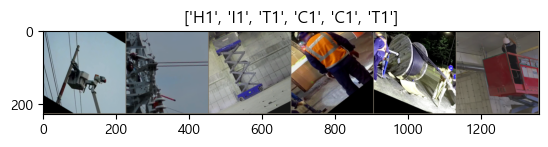

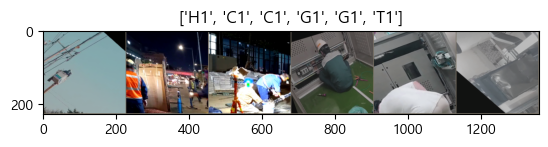

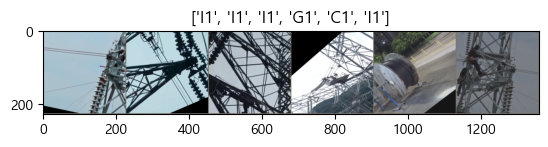

In [19]:
# 데이터 확인
class_names = {
  "0": "C1", # 지중송전설비작업
  "1": "G1", # 변전설비작업
  "2": "H1", # 배전설비작업
  "3": "I1", # 철탑설비작업
  "4": "T1" # 건축전기설비작업
}

plt.rc('font', family="Malgun Gothic")

# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [30]:
# setting
model = model.to(device)

# CUDA 확인
if next(model.parameters()).is_cuda:
  print("Model to CUDA")
else:
  print("Model to CPU")

Model to CUDA


### 손실함수 & 옵티마이저 & 스케쥴러

- Optimizer 변경에 따라 하이퍼 파라미터가 추가로 필요할 시 params 변수 이용

In [31]:
# 손실함수
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저
optimizer_ft = torch.optim.Adam(model.parameters(),
                                lr=params['learning_rate'],
                                betas=params['betas'],
                                weight_decay=params['weight_decay'])

# 스케쥴러
exp_lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_ft,
                                                      lr_lambda=lambda epoch: 0.95 ** epoch,)

### 학습 시작

In [32]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=params['epoch'])


Epoch 1/30: ----------


train:   0%|                                 | 0/1000 [00:00<?, ?it/s]

train: 100%|██████████████████████| 1000/1000 [18:12<00:00,  1.09s/it]



train Loss: 0.18 Acc: 94.1


valid: 100%|████████████████████████| 125/125 [02:39<00:00,  1.28s/it]



valid Loss: 0.75 Acc: 80.7
==> best model saved - 1 / 80.7

Epoch 2/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:56<00:00,  1.08s/it]



train Loss: 0.10 Acc: 96.8


valid: 100%|████████████████████████| 125/125 [02:40<00:00,  1.28s/it]



valid Loss: 0.35 Acc: 85.7
==> best model saved - 2 / 85.7

Epoch 3/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:00<00:00,  1.08s/it]



train Loss: 0.07 Acc: 97.5


valid: 100%|████████████████████████| 125/125 [02:39<00:00,  1.27s/it]



valid Loss: 0.19 Acc: 94.5
==> best model saved - 3 / 94.5

Epoch 4/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:57<00:00,  1.08s/it]



train Loss: 0.05 Acc: 98.4


valid: 100%|████████████████████████| 125/125 [02:39<00:00,  1.28s/it]



valid Loss: 0.13 Acc: 96.1
==> best model saved - 4 / 96.1

Epoch 5/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:07<00:00,  1.09s/it]



train Loss: 0.04 Acc: 98.8


valid: 100%|████████████████████████| 125/125 [02:40<00:00,  1.28s/it]



valid Loss: 0.06 Acc: 97.7
==> best model saved - 5 / 97.7

Epoch 6/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:21<00:00,  1.10s/it]



train Loss: 0.03 Acc: 99.0


valid: 100%|████████████████████████| 125/125 [02:41<00:00,  1.29s/it]



valid Loss: 0.02 Acc: 99.4
==> best model saved - 6 / 99.4

Epoch 7/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:55<00:00,  1.08s/it]



train Loss: 0.02 Acc: 99.2


valid: 100%|████████████████████████| 125/125 [02:40<00:00,  1.29s/it]



valid Loss: 0.01 Acc: 99.5
==> best model saved - 7 / 99.5

Epoch 8/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:40<00:00,  1.06s/it]



train Loss: 0.02 Acc: 99.5


valid: 100%|████████████████████████| 125/125 [02:39<00:00,  1.28s/it]



valid Loss: 0.01 Acc: 99.8
==> best model saved - 8 / 99.8

Epoch 9/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:17<00:00,  1.04s/it]



train Loss: 0.01 Acc: 99.7


valid: 100%|████████████████████████| 125/125 [02:34<00:00,  1.24s/it]



valid Loss: 0.01 Acc: 99.9
==> best model saved - 9 / 99.9

Epoch 10/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:33<00:00,  1.11s/it]



train Loss: 0.01 Acc: 99.6


valid: 100%|████████████████████████| 125/125 [02:37<00:00,  1.26s/it]



valid Loss: 0.01 Acc: 99.8

Epoch 11/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:58<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.26s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 12/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:54<00:00,  1.07s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 100.0
==> best model saved - 12 / 100.0

Epoch 13/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:56<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 14/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:58<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.01 Acc: 99.8

Epoch 15/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:02<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.8

Epoch 16/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:53<00:00,  1.07s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 100.0
==> best model saved - 16 / 100.0

Epoch 17/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:55<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 18/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:59<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:37<00:00,  1.26s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 19/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:54<00:00,  1.07s/it]



train Loss: 0.01 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.8

Epoch 20/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:52<00:00,  1.07s/it]



train Loss: 0.01 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 21/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:52<00:00,  1.07s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 22/30: ----------


train: 100%|██████████████████████| 1000/1000 [18:00<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.26s/it]



valid Loss: 0.00 Acc: 99.8

Epoch 23/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:55<00:00,  1.08s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:38<00:00,  1.27s/it]



valid Loss: 0.00 Acc: 99.8

Epoch 24/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:06<00:00,  1.03s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:31<00:00,  1.21s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 25/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:03<00:00,  1.02s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:32<00:00,  1.22s/it]



valid Loss: 0.00 Acc: 100.0

Epoch 26/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:01<00:00,  1.02s/it]



train Loss: 0.00 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:32<00:00,  1.22s/it]



valid Loss: 0.00 Acc: 99.8

Epoch 27/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:05<00:00,  1.03s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:32<00:00,  1.22s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 28/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:09<00:00,  1.03s/it]



train Loss: 0.00 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:32<00:00,  1.22s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 29/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:11<00:00,  1.03s/it]



train Loss: 0.01 Acc: 99.8


valid: 100%|████████████████████████| 125/125 [02:32<00:00,  1.22s/it]



valid Loss: 0.00 Acc: 99.9

Epoch 30/30: ----------


train: 100%|██████████████████████| 1000/1000 [17:15<00:00,  1.04s/it]



train Loss: 0.00 Acc: 99.9


valid: 100%|████████████████████████| 125/125 [02:33<00:00,  1.22s/it]


valid Loss: 0.00 Acc: 100.0
Training complete in 611m 50s
Best valid Acc: idx=16 0 100.0
model saved


## 학습 결과 분석

best model info:
Model extracted from epoch 17
Valid Acc=100 / Valid Loss=0.0


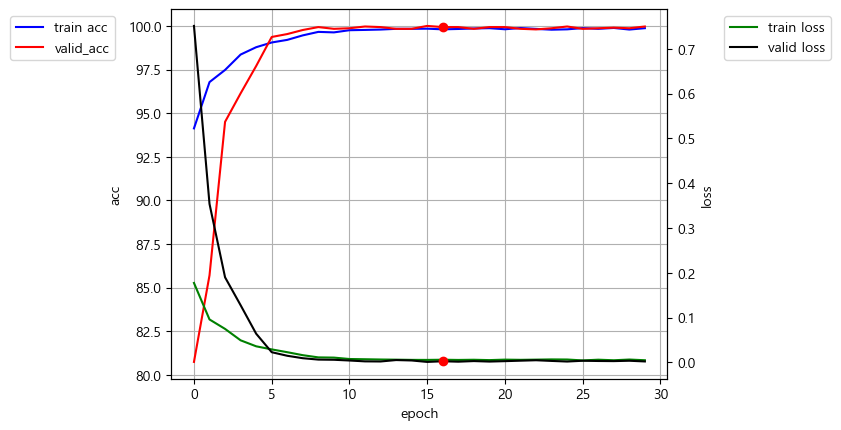

In [33]:
## 결과 그래프 그리기
print('best model info:\nModel extracted from epoch %d\nValid Acc=%1.f / Valid Loss=%.1f'%(best_idx + 1, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-', label='train acc')
ax1.plot(valid_acc, 'r-', label ='valid_acc')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-', label='train loss')
ax2.plot(valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

## 모델 TEST

In [35]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()
  fig = plt.figure()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size
    
    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))
  
  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())], 
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])
      
      if i == 0: break
  
  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 0.00 / 99.9


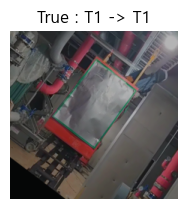

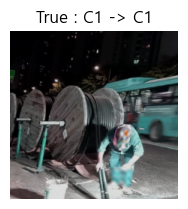

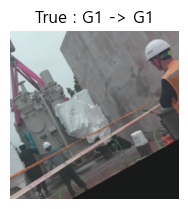

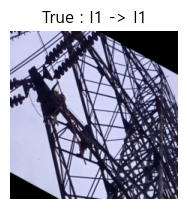

In [36]:
test_and_visualize_model(model, dataloaders, phase='test')

## GradCam을 통한 모델 세부 분석

- Requirement
``` shell
pip install grad-cam
```

### 저장된 학습 완료 모델 파일 이름

In [37]:
pt_file_name = 'industrial_model.pt'

### GradCam 모듈 불러오기

In [38]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

### 저장된 모델 불러오기
- GradCam 적용을 위해 학습완료된 모듈을 불러와 마지막 레이어 이름을 확인합니다.

In [39]:
# 학습이 GPU 상태에서 진행되었는지 CPU 상태에서 진행되었는지 상관 없이 활용할 수 있도록 map_location 매개 변수 통해 장치(device)를 적용합니다.
model_dict = torch.load(pt_file_name, map_location=device)
model_name = 'efficientnet-b0'
trained_model = EfficientNet.from_pretrained(model_name, num_classes=5)
trained_model.load_state_dict(model_dict)
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")
use_CUDA = next(trained_model.parameters()).is_cuda

print(trained_model)
# Grad-Cam은 모델의 순전파 역전파과정 모두 이용함. 모델의 레이어 하나를 가져와야하기 때문에 레이어 확인 필수

Loaded pretrained weights for efficientnet-b0
CUDA:True
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32

### GradCam을 장착하여 모델 Test 및 GradCam 결과 저장

In [40]:
def Denormalize(input):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = params['std'] * input + params['mean']
  input = np.clip(input, 0, 1)
  return input

In [46]:
target_layer = [trained_model._blocks[-1]] # efficientNet-B0의 마지막 Convolution Layer
input_tensor, classes = next(iter(dataloaders['test']))

cam = GradCAM(model=trained_model, target_layers=target_layer, use_cuda=use_CUDA)

targets = [ClassifierOutputTarget(cl) for cl in classes]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

origin_img = []
visualizations = []
for i in range(len(input_tensor)):
 denormalized_image = Denormalize(input_tensor[i])
 origin_img.append(denormalized_image)
 visualizations.append(show_cam_on_image(denormalized_image, grayscale_cam[i, :], use_rgb=True))

### GradCam을 통한 Test 결과 분석

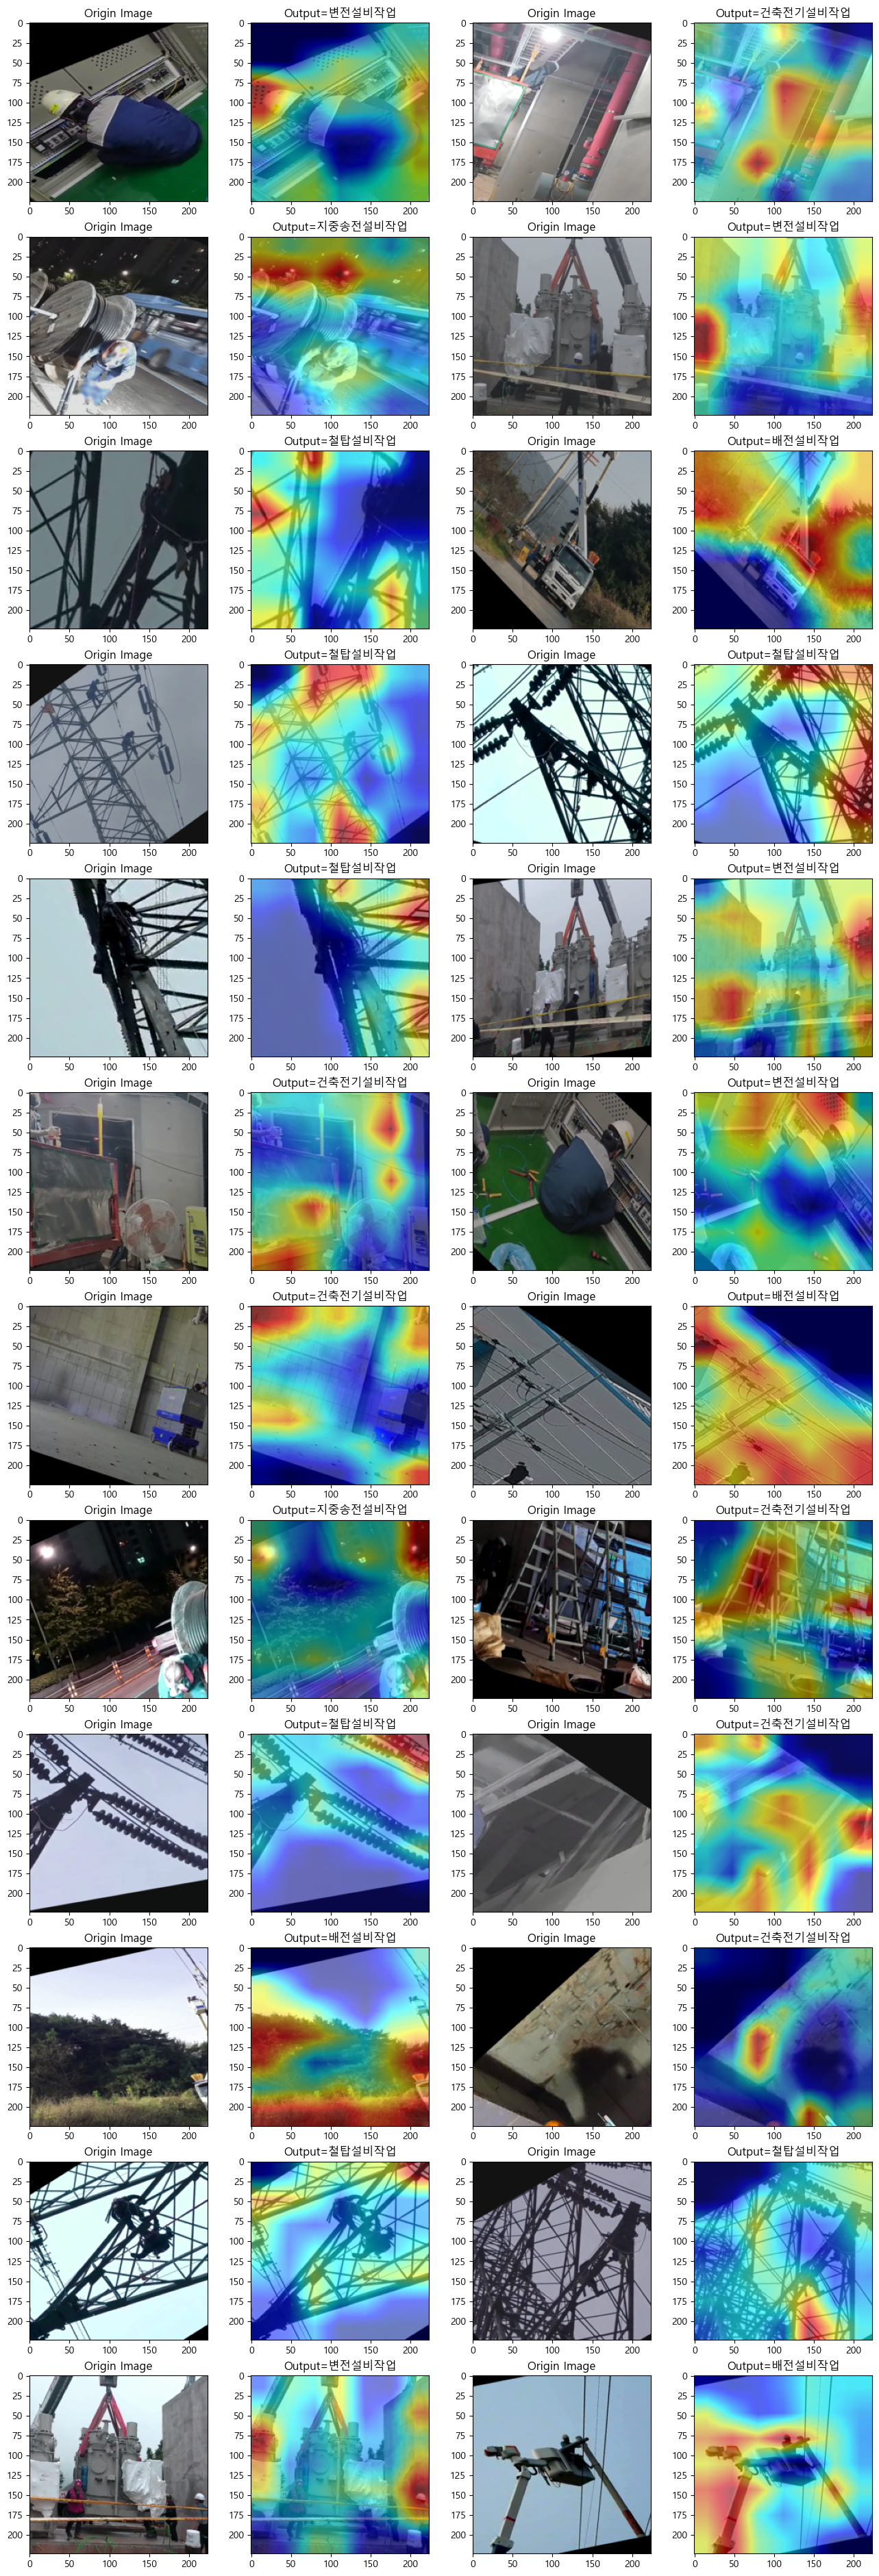

In [47]:
class_names = {
  "0": "지중송전설비작업", # C1
  "1": "변전설비작업", # G1
  "2": "배전설비작업", # H1
  "3": "철탑설비작업", # I1
  "4": "건축전기설비작업" # T1
}

plt.rc('font', family="Malgun Gothic")

scale = 4
cols = 2
rows = len(visualizations) // cols
if len(visualizations) % cols:
  rows += 1

fig, ax = plt.subplots(rows, cols * 2, figsize=(cols * 2 * scale, rows * scale))

for index, img in enumerate(visualizations):
  r, c = index // cols, index % cols * 2
  ax[r, c].imshow(origin_img[index])
  ax[r, c].set_title("Origin Image")
  ax[r, c + 1].imshow(img)
  ax[r, c + 1].set_title("Output=" + class_names[str(int(classes[index]))])